In [15]:
import wfdb
import csv
import pandas as pd
# pour les calculs numériques
import numpy as np
import os

In [16]:
import numpy as np
import tensorflow as tf
import random

# Ce code au début du script, avant toute autre opération liée à TensorFlow ou à la
# manipulation de données, permet d'obtenir des résultats reproductibles à chaque exécution

# Fixer une graine pour NumPy
np.random.seed(42)

# Fixer une graine pour TensorFlow
tf.random.set_seed(42)

# Fixer une graine pour le générateur aléatoire de Python
random.seed(42)

In [17]:
import os
# pour la lecture et l'écriture de fichiers CSV
import csv
# pour la manipulation de données
import pandas as pd
# pour la manipulation des fichiers ECG
import wfdb  # Make sure wfdb is installed

# répertoire de sortie pour stocker les données traitées
output_dir = "data_creation"
os.makedirs(output_dir, exist_ok=True)

# Patient numbers
patient_numbers = [
    "100", "101", "102", "103", "104", "105", "106", "107", "108", "109",
    "111", "112", "113", "114", "115", "116", "117", "118", "119", "121",
    "122", "123", "124", "200", "201", "202", "203", "205", "207", "208",
    "209", "210", "212", "213", "214", "215", "217", "219", "220", "221",
    "222", "223", "228", "230", "231", "232", "233", "234"
]

# pour mapper les symboles d'annotation ECG à des catégories
# N = normal
# S = supra-ventricular premature
# V = ventricular escape
# F = fusion of ventricular and normal
# Q = unclassified heartbeats
symbol_to_category = {
    'N': 'N', '.': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
    'a': 'S', 'A': 'S', 'J': 'S', 'S': 'S',
    'V': 'V', 'E': 'V',
    'F': 'F',
    '/': 'Q', 'f': 'Q', 'Q': 'Q'
}

# Les annotations ECG du patient sont lues et filtrées pour ne garder que celles qui
# correspondent aux symboles définis dans symbol_to_category
# Ces données sont ensuite sauvegardées dans des fichiers CSV distincts dans le répertoire de sortie
for patient_number in patient_numbers:
    try:
        # ECG data
        path_to_record = f"mit-database/{patient_number}"
        patient_record = wfdb.rdrecord(path_to_record)
        leads = patient_record.sig_name
        ecg_data = patient_record.p_signal

        # ECG CSV
        ecg_filename = f"{output_dir}/{patient_number}_ECG.csv"
        with open(ecg_filename, "w", newline='') as outfile:
            out_csv = csv.writer(outfile)
            out_csv.writerow(leads)
            for row in ecg_data:
                out_csv.writerow(row)

        # Annotations data
        annotation = wfdb.rdann(path_to_record, 'atr')
        symbols = annotation.symbol
        annotations = annotation.sample

        # Filter out symbols not in symbol_to_category
        filtered_symbols_annotations = [(sym, ann) for sym, ann in zip(symbols, annotations) if sym in symbol_to_category]
        categories = [symbol_to_category[sym] for sym, ann in filtered_symbols_annotations]
        annotations_filtered = [ann for sym, ann in filtered_symbols_annotations]

        df_annotations = pd.DataFrame({'Category': categories, 'Annotation': annotations_filtered})

        # Annotations CSV
        annotations_filename = f"{output_dir}/{patient_number}_Annotations.csv"
        df_annotations.to_csv(annotations_filename, index=False)

    except Exception as e:
        print(f"Failed to process: {patient_number}: {e}")

print("Done")

Done


In [18]:
import os
import pandas as pd
import numpy as np


# pour traiter les données ECG et annotations pour un patient donné
def process_patient_data(patient_number, data_creation_dir="data_creation"):
    ecg_file_path = os.path.join(data_creation_dir, f"{patient_number}_ECG.csv")
    annotations_file_path = os.path.join(data_creation_dir, f"{patient_number}_Annotations.csv")

    patient_X = []
    patient_Y = []

    try:
        ecg_df = pd.read_csv(ecg_file_path)
        annotations_df = pd.read_csv(annotations_file_path)
    except FileNotFoundError:
        print(f"Files for patient {patient_number} not found. Skipping...")
        return [], []

    first_column_name = ecg_df.columns[0]
    second_column_name = ecg_df.columns[1] if len(ecg_df.columns) > 1 else None

    sampling_rate = 360  # Hz
    total_window_size_seconds = 1  # Total window size in seconds
    total_window_size_samples = total_window_size_seconds * sampling_rate

    # une fenêtre temporelle autour de chaque annotation est extraite des données ECG.
    for _, row in annotations_df.iterrows():
        annotation_point = row['Annotation']
        category = row['Category']

        # Randomly determine the window split around the annotation point
        before_seconds = np.random.uniform(0, total_window_size_seconds)
        after_seconds = total_window_size_seconds - before_seconds
        before_samples = int(before_seconds * sampling_rate)
        after_samples = int(after_seconds * sampling_rate)

        start_point = max(0, annotation_point - before_samples)
        end_point = start_point + total_window_size_samples  # Ensure the window is of the exact expected size

        # Adjust the end point if it exceeds the length of the data
        if end_point > len(ecg_df):
            end_point = len(ecg_df)
            start_point = max(0, end_point - total_window_size_samples)  # Adjust start point accordingly

        # Process data from the first column
        window_data_first_column = ecg_df.iloc[start_point:end_point][first_column_name].to_numpy()

        # Les fenêtres temporelles et les catégories correspondantes sont ajoutées aux listes patient_X et patient_Y
        patient_X.append(window_data_first_column)
        patient_Y.append(category)

        # If there's a second column, process it and add as a new entry
        if second_column_name:
            window_data_second_column = ecg_df.iloc[start_point:end_point][second_column_name].to_numpy()

            patient_X.append(window_data_second_column)
            patient_Y.append(category)  # Repeat category for the new entry

    return patient_X, patient_Y



# Initialize lists to hold the entire dataset
all_X = []
all_Y = []

data_creation_dir = "data_creation"

# données traitées grâce à la fonction 'process_patient_data' puis stockées dans les listes all_X et all_Y
# Process each patient
for patient_number in patient_numbers:
    patient_X, patient_Y = process_patient_data(patient_number, data_creation_dir)
    all_X.extend(patient_X)
    all_Y.extend(patient_Y)

# Conversion en tableaux numpy
X = np.array(all_X)
Y = np.array(all_Y)

In [19]:
X # askip 3 dimensions : temps, numéro du patient et donnée

array([[-0.145, -0.145, -0.145, ..., -0.445, -0.475, -0.51 ],
       [-0.065, -0.065, -0.065, ..., -0.36 , -0.355, -0.305],
       [-0.205, -0.235, -0.225, ..., -0.39 , -0.38 , -0.38 ],
       ...,
       [ 0.045,  0.055,  0.055, ...,  0.04 ,  0.03 ,  0.02 ],
       [-0.31 , -0.305, -0.315, ..., -0.29 , -0.29 , -0.29 ],
       [-0.04 , -0.045, -0.06 , ...,  0.085,  0.07 ,  0.085]])

In [20]:
Y

array(['N', 'N', 'N', ..., 'N', 'N', 'N'], dtype='<U1')

In [21]:
# Dimensions
print(X.shape)
print(Y.shape)

# type de données
print(X.dtype)
print(Y.dtype)

(218988, 360)
(218988,)
float64
<U1


In [22]:
# Convertir X en DataFrame
df_x = pd.DataFrame(X)
df_x

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.120,-0.135,...,-0.325,-0.330,-0.350,-0.365,-0.360,-0.380,-0.425,-0.445,-0.475,-0.510
1,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.080,-0.080,...,-0.235,-0.250,-0.270,-0.280,-0.290,-0.300,-0.330,-0.360,-0.355,-0.305
2,-0.205,-0.235,-0.225,-0.245,-0.250,-0.260,-0.275,-0.275,-0.275,-0.265,...,-0.450,-0.475,-0.455,-0.425,-0.390,-0.390,-0.385,-0.390,-0.380,-0.380
3,-0.090,-0.095,-0.090,-0.095,-0.110,-0.120,-0.145,-0.135,-0.105,-0.095,...,-0.345,-0.310,-0.295,-0.285,-0.295,-0.295,-0.280,-0.285,-0.285,-0.285
4,-0.390,-0.405,-0.395,-0.385,-0.375,-0.390,-0.390,-0.405,-0.410,-0.410,...,-0.420,-0.425,-0.415,-0.415,-0.410,-0.435,-0.430,-0.435,-0.420,-0.420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218983,0.040,0.035,0.020,0.000,-0.010,-0.015,-0.035,-0.050,-0.050,-0.035,...,0.085,0.085,0.075,0.060,0.055,0.055,0.060,0.070,0.060,0.045
218984,-0.210,-0.225,-0.225,-0.240,-0.240,-0.240,-0.240,-0.225,-0.235,-0.235,...,-0.305,-0.330,-0.365,-0.390,-0.405,-0.405,-0.400,-0.400,-0.400,-0.395
218985,0.045,0.055,0.055,0.050,0.050,0.045,0.035,0.035,0.025,0.030,...,0.050,0.025,0.000,-0.015,0.005,0.010,0.025,0.040,0.030,0.020
218986,-0.310,-0.305,-0.315,-0.320,-0.325,-0.310,-0.290,-0.295,-0.285,-0.285,...,-0.290,-0.310,-0.315,-0.310,-0.305,-0.295,-0.285,-0.290,-0.290,-0.290


In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_x = scaler.fit_transform(df_x)
df_x = pd.DataFrame(df_x)

In [25]:
import pywt

def madev(d, axis=None):
    'Mean absolute deviation of a signal'
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def wavelet_denoising(x, wavelet='sym4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')


df_x = wavelet_denoising(df_x, wavelet='sym4', level=2)
df_x = pd.DataFrame(df_x)

In [26]:
# Convertir en DataFrame avec qu'une colonne 'ColumnName'
df_y = pd.DataFrame(Y, columns=['ColumnName'])
print(df_y)

       ColumnName
0               N
1               N
2               N
3               N
4               N
...           ...
218983          N
218984          N
218985          N
218986          N
218987          N

[218988 rows x 1 columns]


In [27]:
# Compte le nombre de répétitions dans chaque catégories
value_counts_y = df_y['ColumnName'].value_counts()
print(value_counts_y)

ColumnName
N    181262
Q     16086
V     14472
S      5562
F      1606
Name: count, dtype: int64


In [30]:
df_y.to_csv('df_y.csv', index=False)
df_x.to_csv('df_x.csv', index=False)


In [28]:
# Créer un DataFrame où les données X et Y sont placées sur un seul axe à la suite
df_fusionné = pd.concat([df_y, df_x], axis=1)
df_fusionné

,ColumnName,0,1,2,3,4,5,6,7,8,...,350,351,352,353,354,355,356,357,358,359
0,N,0.462657,0.482548,0.484076,0.480509,0.483015,0.486312,0.486521,0.485864,0.486532,...,0.465025,0.465029,0.464824,0.464402,0.465701,0.466904,0.465382,0.464323,0.457096,0.448836
1,N,0.482615,0.482879,0.483021,0.482990,0.483850,0.485008,0.486124,0.487286,0.488439,...,0.481455,0.483832,0.481466,0.477827,0.472715,0.467784,0.468938,0.472220,0.476545,0.481245
2,N,0.476634,0.476991,0.476890,0.476314,0.476720,0.477318,0.477692,0.477965,0.477989,...,0.460408,0.458733,0.455923,0.453966,0.452707,0.452627,0.456283,0.461277,0.467851,0.474552
3,N,0.485052,0.485724,0.486199,0.486419,0.486915,0.487455,0.487805,0.488118,0.488656,...,0.463174,0.470400,0.471681,0.471369,0.471005,0.470679,0.473046,0.476238,0.479891,0.483542
4,N,0.460283,0.460354,0.460425,0.460504,0.460599,0.460698,0.460807,0.460913,0.460964,...,0.460193,0.460195,0.460194,0.460194,0.460202,0.460213,0.460214,0.460218,0.460221,0.460232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218983,N,0.504360,0.503927,0.503484,0.502999,0.502451,0.501895,0.501284,0.500694,0.500345,...,0.505341,0.505192,0.505112,0.505058,0.504968,0.504872,0.504834,0.504783,0.504750,0.504677
218984,N,0.470898,0.471617,0.472329,0.472988,0.473611,0.474224,0.474766,0.475305,0.476068,...,0.465742,0.461986,0.461522,0.462381,0.463621,0.465271,0.466413,0.467441,0.468726,0.470013
218985,N,0.500709,0.501071,0.501544,0.502152,0.502651,0.503131,0.503708,0.504286,0.504697,...,0.505848,0.503933,0.503743,0.503993,0.504325,0.504639,0.503961,0.503012,0.501867,0.500769
218986,N,0.471186,0.471236,0.471310,0.471411,0.471511,0.471623,0.471755,0.471905,0.472077,...,0.471733,0.471866,0.471858,0.471788,0.471710,0.471613,0.471508,0.471407,0.471289,0.471186


In [29]:
df_fusionné.to_csv('df_fusionné.csv', index=False)


In [ ]:
# Applique une fonction anonyme à la première colonne du DataFrame fusionné pour binariser les étiquettes
# Dans ce cas, si la valeur de l'étiquette est différente de 'N', elle est remplacée par 0, sinon elle est remplacée par 1
df_fusionné_binaire = df_fusionné.copy()
df_fusionné_binaire.iloc[:, 0] = df_fusionné_binaire.iloc[:, 0].apply(lambda x: 0 if x != 'N' else 1)

In [ ]:
df_fusionné_binaire

,ColumnName,0,1,2,3,4,5,6,7,8,...,350,351,352,353,354,355,356,357,358,359
0,1,0.462657,0.482548,0.484076,0.480509,0.483015,0.486312,0.486521,0.485864,0.486532,...,0.465025,0.465029,0.464824,0.464402,0.465701,0.466904,0.465382,0.464323,0.457096,0.448836
1,1,0.482615,0.482879,0.483021,0.482990,0.483850,0.485008,0.486124,0.487286,0.488439,...,0.481455,0.483832,0.481466,0.477827,0.472715,0.467784,0.468938,0.472220,0.476545,0.481245
2,1,0.476634,0.476991,0.476890,0.476314,0.476720,0.477318,0.477692,0.477965,0.477989,...,0.460408,0.458733,0.455923,0.453966,0.452707,0.452627,0.456283,0.461277,0.467851,0.474552
3,1,0.485052,0.485724,0.486199,0.486419,0.486915,0.487455,0.487805,0.488118,0.488656,...,0.463174,0.470400,0.471681,0.471369,0.471005,0.470679,0.473046,0.476238,0.479891,0.483542
4,1,0.460283,0.460354,0.460425,0.460504,0.460599,0.460698,0.460807,0.460913,0.460964,...,0.460193,0.460195,0.460194,0.460194,0.460202,0.460213,0.460214,0.460218,0.460221,0.460232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218983,1,0.504360,0.503927,0.503484,0.502999,0.502451,0.501895,0.501284,0.500694,0.500345,...,0.505341,0.505192,0.505112,0.505058,0.504968,0.504872,0.504834,0.504783,0.504750,0.504677
218984,1,0.470898,0.471617,0.472329,0.472988,0.473611,0.474224,0.474766,0.475305,0.476068,...,0.465742,0.461986,0.461522,0.462381,0.463621,0.465271,0.466413,0.467441,0.468726,0.470013
218985,1,0.500709,0.501071,0.501544,0.502152,0.502651,0.503131,0.503708,0.504286,0.504697,...,0.505848,0.503933,0.503743,0.503993,0.504325,0.504639,0.503961,0.503012,0.501867,0.500769
218986,1,0.471186,0.471236,0.471310,0.471411,0.471511,0.471623,0.471755,0.471905,0.472077,...,0.471733,0.471866,0.471858,0.471788,0.471710,0.471613,0.471508,0.471407,0.471289,0.471186


In [ ]:
Y_anormal = df_y[df_y["ColumnName"] != "N"]
Y_anormal

,ColumnName
14,S
15,S
460,S
461,S
516,S
...,...
216643,V
217442,V
217443,V
218702,V


In [ ]:
# on met Y en binaire avec 1 quand l'ECG est normal, et 0 sinon
#Y_binaire = np.where(Y != 'N', 0, 1)
#Y_binaire

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Supprimer les valeurs de X pour lesquelles Y vaut N pour avoir le meme nombre d'échantillons entre X et Y
# Trouver les indices où les valeurs de Y sont 'N'
indices_a_supprimer = np.where(Y == 'N')[0]
# Supprimer les lignes correspondantes de X
X_anormal = np.delete(X, indices_a_supprimer, axis=0)

# On utilise la classe StabdarScaler pour normaliser nos données d'entrées
# Ici, on normalise car les réseaux de neurones sont sensibles à l'échelle des données
# Ca permet d'avoir des données avec une distribution standardisée
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_anormal)
print(X_normalized)

# pour encoder les sorties anormales
# on aura 1 au niveau de la colonne représentant la classe en question
encoder = OneHotEncoder()
Y_encode = encoder.fit_transform(np.array(Y_anormal).reshape(-1, 1)).toarray()
print(Y_encode)

# Encoder sert à par exemple qd on a une colonne genre avec feminin ou masculin, créer 2 colonnes
# genre_feminin et genre_masculin avec 0 ou 1 suivant si la prsn est une femme ou un homme
# On encode généralement pour des données catégorielles (one hot encoding comme décrit plus haut) ou textuelles (word embedding)
# Avec notre Y_binaire, on a  pas besoin d'encoder car déjà une valeur numérique

[[-0.36245625 -0.31452406 -0.27678503 ... -0.36754502 -0.39071396
  -0.39740526]
 [-0.07814522 -0.04130521 -0.08009007 ... -0.02581042 -0.03986295
  -0.04525038]
 [-0.41931846 -0.39931612 -0.38918215 ... -0.30245271 -0.30912071
  -0.32369843]
 ...
 [-2.51374308 -2.50969625 -2.4872617  ...  0.24269533  0.18859817
   0.20862872]
 [-0.16343853 -0.15436128 -0.16438791 ... -0.26177002 -0.25200543
  -0.29093983]
 [ 0.10191844  0.08117221  0.10723846 ...  0.2996511   0.30282873
   0.2905252 ]]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [ ]:
print(X_normalized.shape)
print(Y_encode.shape)

(37726, 360)
(37726, 4)


In [ ]:
from sklearn.model_selection import train_test_split

# Réduire X et Y à 20% de leur taille
X_reduit, _, Y_reduit, _ = train_test_split(X_normalized, Y_encode, test_size=0.8, random_state=42)  # Conserve 20%, ignore 80%
# Split des données en test et entrainement
X_train, X_test, Y_train, Y_test = train_test_split(X_reduit, Y_reduit, test_size=0.2, random_state=42) # random_state pour fixer une graine aléatoire afin que les résultats soient toujours les memes, que tu recompiles ou non

In [ ]:
# Dimensions de X_train
print(X_train.shape)
print(Y_train.shape)

# 3017 données
# colonnes en entrée  (1440) pour le nombre de fenetres étudiées
# colonnes en sortie (4) pour dire l'état d'ecg (valeur 1 ans la colonne correspondante)

(6036, 360)
(6036, 4)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten

# Construction du modèle
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)), # première couche de convolution
    MaxPooling1D(pool_size=2), # toujours associer à une couche de pooling pour réduire la dimensionnalité
    Flatten(), # pour applatir les sorties des couches précédentes en un vecteur pour pouvoir les connecter à des couches entièrement connectées
    Dense(32, activation='relu'),  # première couche entièrement connectée
                                  # à 100 neurones ca plantait donc j'ai mis 32
                                  # (détermine la complexité du modèle avec sa capacité à apprendre des relations complexes entre les caractéristiques (X))
                                  # c'est mieux de choisir un nombre de neurones en 2^
    Dense(4, activation='softmax') # deuxième avec une activation softmax pour prédire les proba des classes de sortie (ici que Y)
    # 4 neurones pour la dernière couche car 4 classes de sortie
])

# le nombre de filtres détermine le nb de caracteristiques ou de motifs différents que la couche peut extraire des données
# la taille du noyau détermine la taille de la fenetre utilisée pour calculer les convolutions sur les données d'entrée X
# la fonction d'activation est généralement relu pr controler la non linéarité dans le modèle puis softmax pr les proba

In [ ]:
# Compilation du modèle

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# ici on choisit la fonction de perte categorical_crossentropy car notre sortie Y est une catégorisation à 4 classes en fction de l'anomalie
# on peut aussi choisir la fonction de perte binary_crossentropy si notre sortie Y était binaire (normal ou anormal par exemple)
# l'optimiseur met à jour les poids du modèle lors de l'entrainement pr minimiser la fonction de perte et est généralement adam, sgd..
# métriques pour évaluer les performances du modèle donc ici on choisit la précision

In [ ]:
# Entrainement du modèle

model.fit(X_train, Y_train, epochs=2, batch_size=10, validation_data=(X_test, Y_test)) # normalement 10 et 32 mais plante

Epoch 1/2
604/604 [==============================] - 7s 10ms/step - loss: 1.0106 - accuracy: 0.5331 - val_loss: 0.8425 - val_accuracy: 0.6720
Epoch 2/2
604/604 [==============================] - 6s 10ms/step - loss: 0.7865 - accuracy: 0.6807 - val_loss: 0.7597 - val_accuracy: 0.6925


48/48 [==============================] - 0s 8ms/step


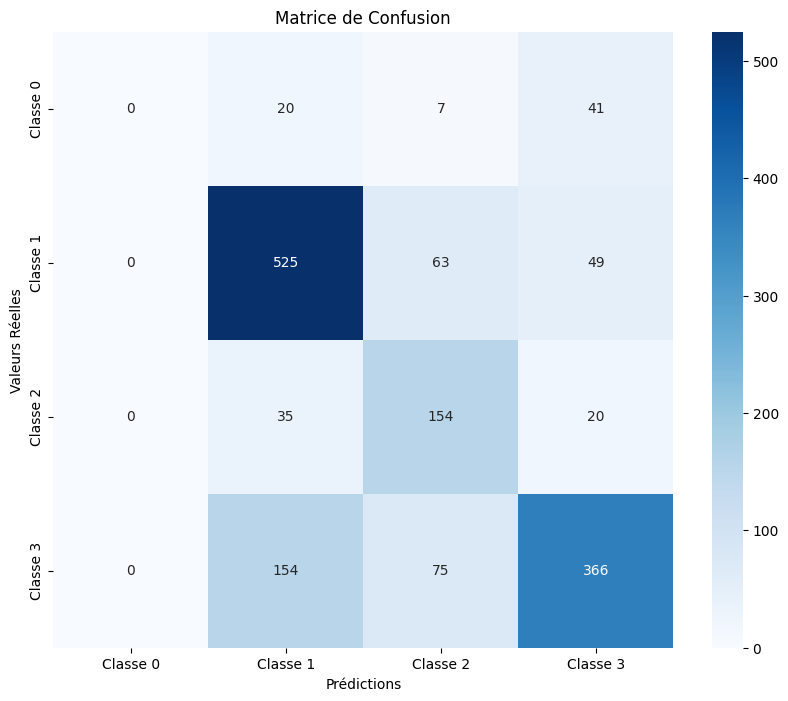

Rapport de classification :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        68
           1       0.72      0.82      0.77       637
           2       0.52      0.74      0.61       209
           3       0.77      0.62      0.68       595

    accuracy                           0.69      1509
   macro avg       0.50      0.54      0.51      1509
weighted avg       0.68      0.69      0.68      1509



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Faire des prédictions sur l'ensemble de test
Y_pred = model.predict(X_test)

# Convertir les prédictions en étiquettes de classe
predicted_labels = np.argmax(Y_pred, axis=1)
true_labels = np.argmax(Y_test, axis=1)

# Créer la matrice de confusion
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Affichage de la matrice de confusion avec Seaborn pour une visualisation améliorée
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[f"Classe {i}" for i in range(np.max(true_labels) + 1)], yticklabels=[f"Classe {i}" for i in range(np.max(true_labels) + 1)])
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs Réelles")
plt.show()

# Affichage du rapport de classification pour fournir des métriques supplémentaires
print("Rapport de classification :")
print(classification_report(true_labels, predicted_labels))


In [ ]:
#pip install keras-tuner

In [ ]:
'''import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
        activation='relu',
        input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('units', min_value=32, max_value=128, step=32),
        activation='relu'))
    model.add(Dense(4, activation='softmax'))  # Présupposant toujours 4 classes de sortie.

    # Utilisation de categorical_crossentropy
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model


# Create a tuner
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

# Create a callback to stop training early after reaching a certain value for the validation loss
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Execute the hyperparameter search
tuner.search(X_train, Y_train,
             epochs=50,
             validation_data=(X_test, Y_test),
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of filters in the conv1D layer is {best_hps.get('filters')}.
The optimal kernel size is {best_hps.get('kernel_size')}.
The optimal number of units in the first Dense layer is {best_hps.get('units')}.
And the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train, epochs=50, validation_data=(X_test, Y_test))'''


'import keras_tuner as kt\nimport tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten\nfrom tensorflow.keras.optimizers import Adam\n\ndef build_model(hp):\n    model = Sequential()\n    model.add(Conv1D(\n        filters=hp.Int(\'filters\', min_value=32, max_value=128, step=32),\n        kernel_size=hp.Choice(\'kernel_size\', values=[3, 5, 7]),\n        activation=\'relu\',\n        input_shape=(X_train.shape[1], 1)))\n    model.add(MaxPooling1D(pool_size=2))\n    model.add(Flatten())\n    model.add(Dense(\n        units=hp.Int(\'units\', min_value=32, max_value=128, step=32),\n        activation=\'relu\'))\n    model.add(Dense(4, activation=\'softmax\'))  # Présupposant toujours 4 classes de sortie.\n\n    # Utilisation de categorical_crossentropy\n    model.compile(\n        optimizer=Adam(hp.Choice(\'learning_rate\', values=[1e-2, 1e-3, 1e-4])),\n        loss=\'categorical_crossentropy\',\n      

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam

# Définition du modèle avec les meilleurs hyperparamètres trouvés
def build_best_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(4, activation='softmax')  # Supposons que vous avez 4 classes de sortie
    ])

    # Compilation du modèle avec le meilleur taux d'apprentissage trouvé
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',  # Assurez-vous que vos étiquettes sont encodées en one-hot
                  metrics=['accuracy'])
    return model

# Présumant que X_train.shape[1] donne la deuxième dimension de votre ensemble de données d'entrée
best_model = build_best_model((X_train.shape[1], 1))

# Entraînement du modèle (assurez-vous que vos données sont prêtes et que les callbacks sont configurés si nécessaire)
history = best_model.fit(X_train, Y_train, epochs=50, validation_data=(X_test, Y_test))

# Vous pouvez ajuster les epochs et les callbacks selon vos besoins


Epoch 1/50
189/189 [==============================] - 11s 51ms/step - loss: 0.9519 - accuracy: 0.5919 - val_loss: 0.7787 - val_accuracy: 0.7104
Epoch 2/50
189/189 [==============================] - 6s 33ms/step - loss: 0.7027 - accuracy: 0.7333 - val_loss: 0.6582 - val_accuracy: 0.7707
Epoch 3/50
189/189 [==============================] - 5s 28ms/step - loss: 0.5510 - accuracy: 0.8058 - val_loss: 0.6292 - val_accuracy: 0.7800
Epoch 4/50
189/189 [==============================] - 8s 43ms/step - loss: 0.4502 - accuracy: 0.8383 - val_loss: 0.5878 - val_accuracy: 0.7972
Epoch 5/50
189/189 [==============================] - 5s 28ms/step - loss: 0.3666 - accuracy: 0.8723 - val_loss: 0.5945 - val_accuracy: 0.7985
Epoch 6/50
189/189 [==============================] - 5s 27ms/step - loss: 0.3048 - accuracy: 0.8993 - val_loss: 0.5659 - val_accuracy: 0.8111
Epoch 7/50
189/189 [==============================] - 8s 45ms/step - loss: 0.2559 - accuracy: 0.9178 - val_loss: 0.5719 - val_accuracy: 0.820

48/48 [==============================] - 0s 8ms/step


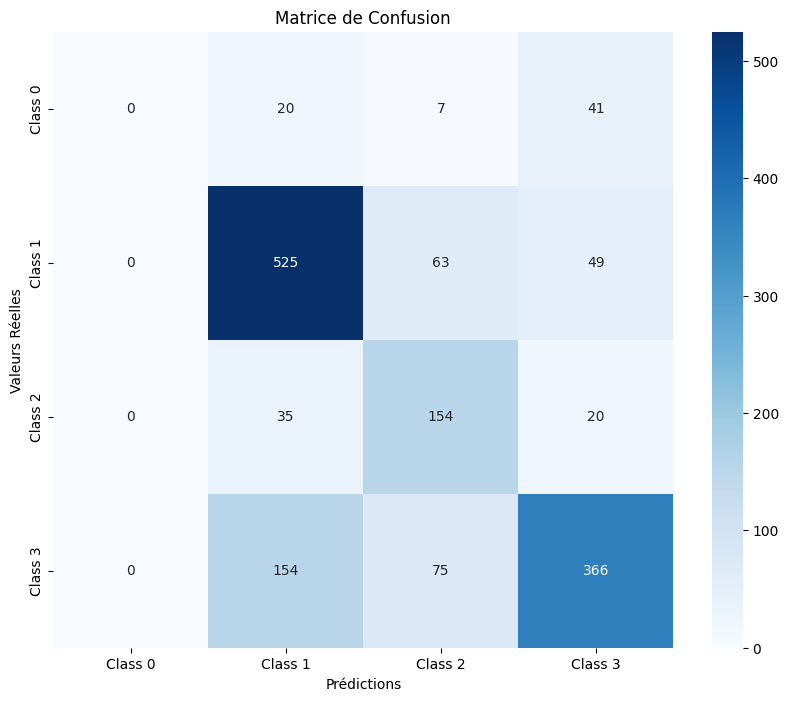

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        68
           1       0.72      0.82      0.77       637
           2       0.52      0.74      0.61       209
           3       0.77      0.62      0.68       595

    accuracy                           0.69      1509
   macro avg       0.50      0.54      0.51      1509
weighted avg       0.68      0.69      0.68      1509



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prédiction des étiquettes sur l'ensemble de test
Y_pred = model.predict(X_test)
predicted_labels = np.argmax(Y_pred, axis=1)

# Si Y_test est encodé en one-hot, convertissez-le en étiquettes entières
true_labels = np.argmax(Y_test, axis=1)

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Affichage de la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[f"Class {i}" for i in range(4)], yticklabels=[f"Class {i}" for i in range(4)])
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.show()

# Affichage du rapport de classification pour plus de détails
print(classification_report(true_labels, predicted_labels))
